# Bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

# Funções Auxiliares

In [2]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# Carregando os Dados

In [3]:
#Carrega o dataset
df = read_csv('./data/Eletrical_Production.csv', names=['KW'], usecols=[1], header=0)
df.head(10)

,KW
0,3.3842
1,3.4100
2,3.4875
3,3.5133
4,3.5133
5,3.5650
6,3.5650
7,3.6167
8,3.7200
9,3.7200


In [4]:
X = df.values
X = X.astype('float32')
X.shape

(964, 1)

<AxesSubplot:title={'center':'Dados Totais'}, ylabel='KW'>

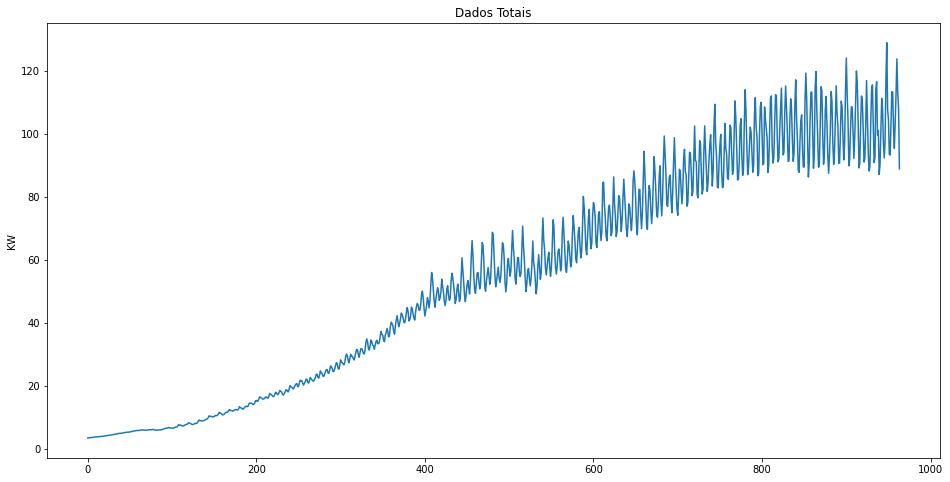

In [5]:
plt.figure(figsize=(16,8))
plt.title('Dados Totais')
sns.lineplot(x=df.index, y=df.KW)

# Normalizando os Dados com MinMax Scaler

## Dados finais entre 0 e 1

In [6]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Dividindo os dados entre Treino, Validação e Teste. com 70%, 10% e 20%. 

In [7]:
train_size = int(len(X) * 0.7)
validation_size = int(len(X) * 0.1)
test_size = int(len(X) * 0.2)

train = X[0:train_size, :]
validation = X[train_size:train_size + validation_size, :]
test =  X[train_size + validation_size:len(X), :]

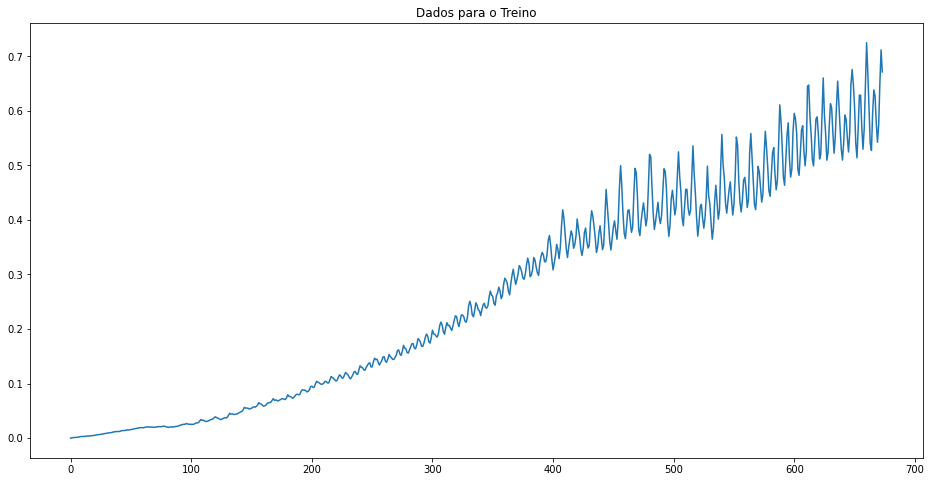

In [8]:
plt.figure(figsize=(16,8))
plt.title('Dados para o Treino')
plt.plot(train)

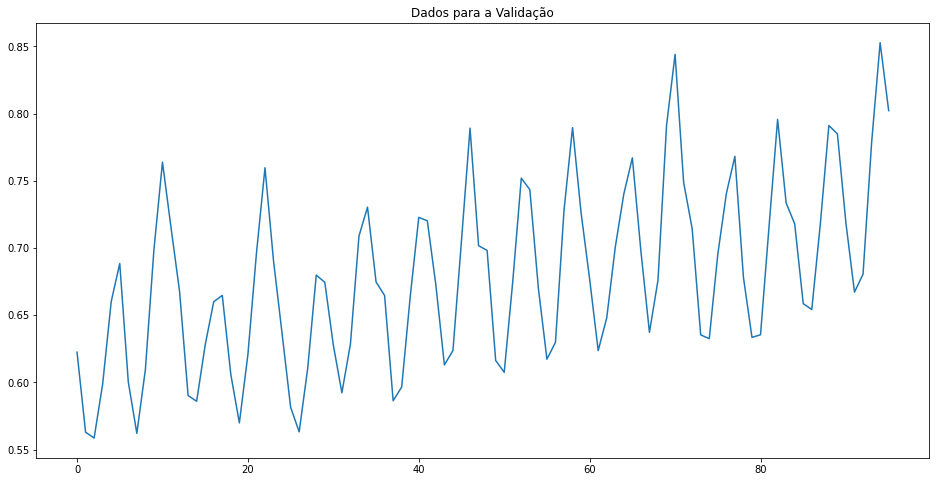

In [9]:
plt.figure(figsize=(16,8))
plt.title('Dados para a Validação')
plt.plot(validation)

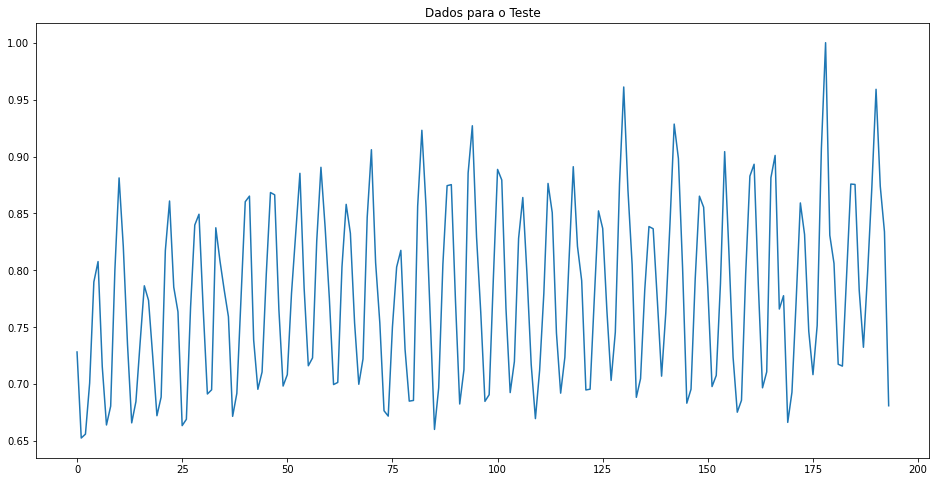

In [10]:
plt.figure(figsize=(16,8))
plt.title('Dados para o Teste')
plt.plot(test)

# Criando a Base de treino com o Loopback 

In [11]:
# quantidade de atrasos
look_back = 10

X_train, y_train = create_dataset(train, look_back)
X_validation, y_validation = create_dataset(validation, look_back)
X_test, y_test = create_dataset(test, look_back)


In [12]:
X_train.shape

(663, 10)

In [13]:
# reshape da entrada para ser [amostras, time steps, caracteristicas]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [14]:
X_train.shape

(663, 10, 1)

In [15]:
X_train[0]

array([[0.        ],
       [0.00020554],
       [0.00082296],
       [0.0010285 ],
       [0.0010285 ],
       [0.00144037],
       [0.00144037],
       [0.00185225],
       [0.00267521],
       [0.00267521]], dtype=float32)

In [16]:
y_train[0]

0.0028807484

# Criando a rede LSTM

In [17]:
# Cria e treina a rede LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))

## Treinando o modelo

In [18]:
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=100, batch_size=1, verbose=0)

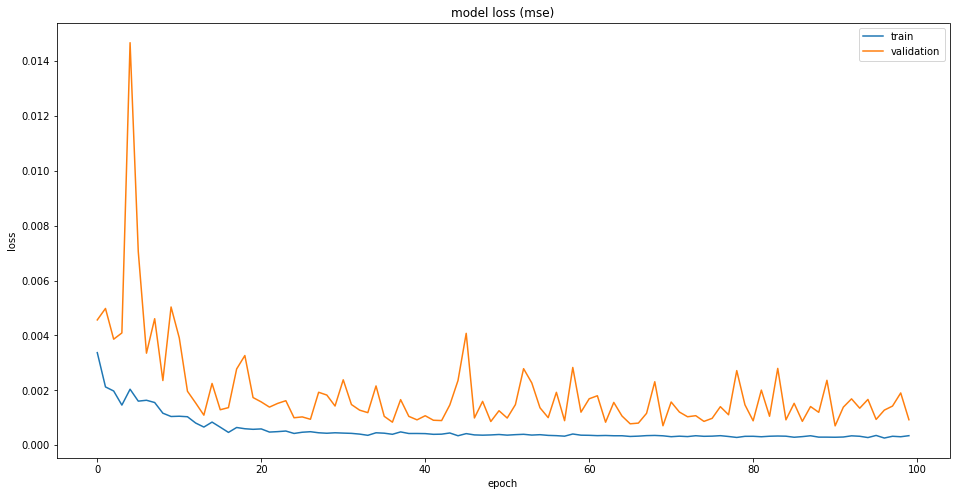

In [19]:
fig = plt.figure(figsize=(16,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (mse)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [20]:
# Predições
trainPredict = model.predict(X_train)
ValidationPredict = model.predict(X_validation)
testPredict = model.predict(X_test)

In [21]:
# Faz a transformação inversa das predições
trainPredict = scaler.inverse_transform(trainPredict)
y_train_p = scaler.inverse_transform([y_train])
ValidationPredict = scaler.inverse_transform(ValidationPredict)
y_validation_p = scaler.inverse_transform([y_validation])
testPredict = scaler.inverse_transform(testPredict)
y_test_p = scaler.inverse_transform([y_test])

## Apresentando a RMSE do Treino e do Teste

In [22]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(y_train_p[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_p[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.58 RMSE
Test Score: 6.85 RMSE


In [23]:
len(trainPredict)

663

In [24]:
# Prepara o vetor para plotagem do conjunto de treinamento
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back-1:len(trainPredict)+look_back-1, :] = trainPredict

In [25]:
len(testPredict)

183

In [26]:
# Prepara o vetor para plotagem do conjunto das predições
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(ValidationPredict)+(look_back*3):len(X)-3, :] = testPredict

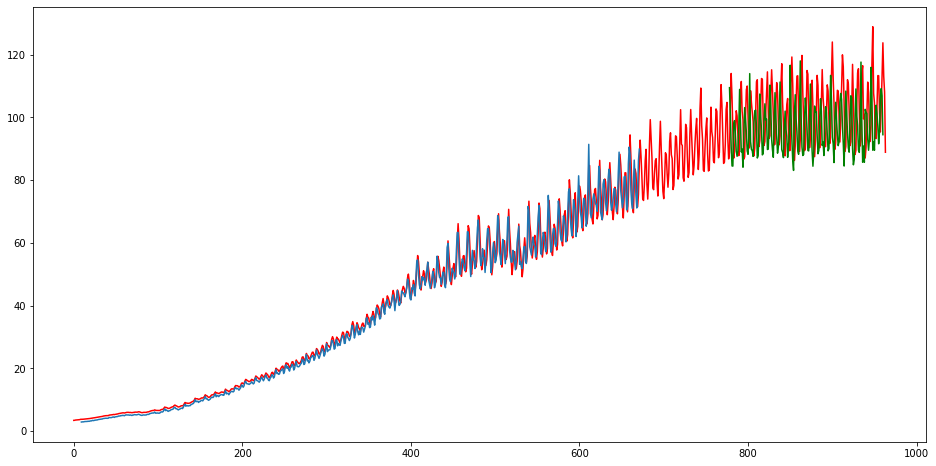

In [27]:
# Plota o dataset, as predições sobre o conjunto de treinamento e teste
plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(X), color='r')
plt.plot(trainPredictPlot)
#plt.plot(validationPredictPlot)
plt.plot(testPredictPlot, color='g')
plt.show()